In [61]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from timer import Timer

In [62]:
def buildTree(S, vol, T, N):
    dt = T / N
    matrix = np.zeros((N + 1, N + 1))
    matrix[0, 0] = S
    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    
    for i in np.arange(N + 1):
        for j in np.arange(i + 1):
            matrix[i, j] = S * u**(j) * d**(i - j)
    return matrix

def valueOptionMatrix(tree, T, r, K, vol, N):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Print the original tree for reference
    #print(tree)

    # Walk backward, add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c]
        tree[rows - 1, c] = max(S - K, 0)

    # For all other rows, combine from previous rows
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            tree[i, j] = np.exp(-r * dt) * (p * up + (1 - p) * down)


    return tree

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price, norm.cdf(d1)

def hedge_param(tree, option_tree):
    delta = (option_tree[1,1] - option_tree[1,0]) / (tree[1,1] - tree[1,0])
    # print(option_tree[1,1], option_tree[1,0], tree[1,1], tree[1,0])
    return delta



In [63]:
S = 100
T = 1.
N = 50
K = 99
r = 0.06
sigma = 0.2

In [64]:
print("Value of european call option using binomial tree with N=50: ", valueOptionMatrix(buildTree(S, sigma, T, N), T, r, K, sigma, N)[0, 0])

Value of european call option using binomial tree with N=50:  11.546434850755071


In [65]:
N = np.arange(1 , 300)
optionPriceAnalytical = black_scholes_call(S, K, T, r, sigma)[0] 
f0s = []
time_run = []


In [66]:
for n in N:
    
    t = Timer()
    t.start()
    treeN = buildTree(S, sigma, T, n) # TODO
    priceApproximatedly = valueOptionMatrix(treeN, T, r, K, sigma, n)
    time_run.append(t.stop())
    f0s.append(priceApproximatedly[0,0])


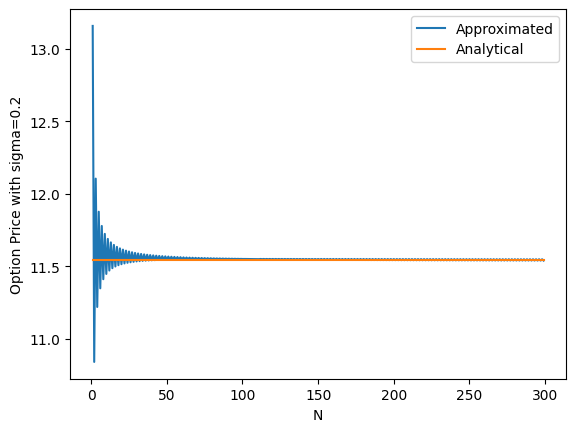

In [67]:
plt.plot(N, f0s, label='Approximated')
plt.plot(N, optionPriceAnalytical*np.ones(len(N)), label='Analytical')
plt.xlabel('N')
plt.ylabel('Option Price with sigma=0.2')
plt.legend()
plt.show()


Volatility 0.05 converges after 8 time steps
Volatility 0.1 converges after 23 time steps
Volatility 0.15 converges after 43 time steps
Volatility 0.2 converges after 67 time steps
Volatility 0.25 converges after 89 time steps
Volatility 0.3 converges after 112 time steps
Volatility 0.35 converges after 133 time steps
Volatility 0.4 converges after 153 time steps
Volatility 0.45 converges after 171 time steps


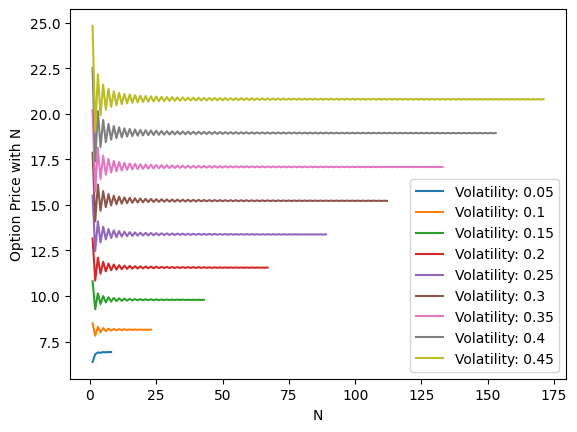

In [68]:

sigma = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45]
N = np.arange(1 , 300)
S = 100

# Checking how many time steps it takes certain sigmas to converge
for vol in sigma:


    res_prev = 0
    option_price = []
    for n in N:

        treeN = buildTree(S, vol, T, n)
        priceApproximatedly = valueOptionMatrix(treeN, T, r, K, vol, n)
        diff = (abs(priceApproximatedly[0,0] - res_prev)) / ((priceApproximatedly[0,0] + res_prev) / 2) * 100
        res_prev = priceApproximatedly[0,0]
        option_price.append(priceApproximatedly[0,0])
        # If change in percentage is within 0.01%
        if diff < 0.1:
            print("Volatility", vol, "converges after", n, "time steps")
            break
    plt.plot(N[:len(option_price)], option_price, label='Volatility: ' + str(vol))
plt.xlabel('N')
plt.ylabel('Option Price with N')
plt.legend()
plt.show()

    


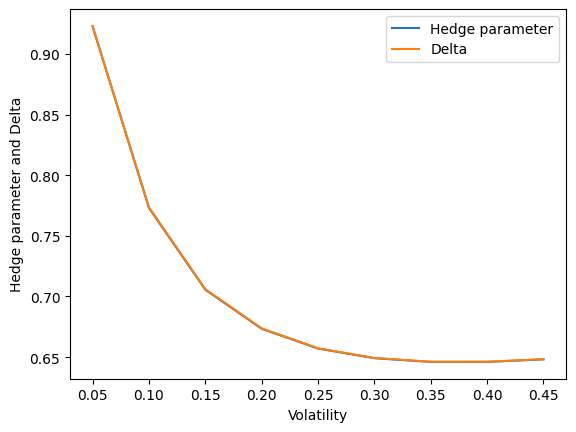

In [69]:
N =200
hedge_param_list = []
delta_list = []

for vol in sigma:
    hedge = hedge_param(buildTree(S, vol, T, N), valueOptionMatrix(buildTree(S, vol, T, N), T, r, K, vol, N))
    hedge_param_list.append(hedge)
    delta = black_scholes_call(S, K, T, r, vol)[1]
    delta_list.append(delta)

plt.plot(sigma, hedge_param_list, label='Hedge parameter')
plt.plot(sigma, delta_list, label='Delta')
plt.xlabel('Volatility')
plt.ylabel('Hedge parameter and Delta')
plt.legend()
plt.show()
